# Tranfer learning

We will continue working on the chest x-ray dataset, from [Kermany et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418301545?via%3Dihub)
 but this time we will stand closer to the original paper because we will use transfer learning.

![fig 1 of "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning" by Kermany et al.](images/tranfer_learning_xray.jpg)

The base model we will re-use is [ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) from [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).



With inspirations from [this github repo](https://github.com/liyu95/Deep_learning_examples/blob/master/4.ResNet_X-ray_classification/Densenet_fine_tune.ipynb) and [this kaggle thread](https://www.kaggle.com/code/iamsdt/transferlearning-pytorch-resnet-50)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader

from torchvision.transforms import v2
import torchvision

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


/home/wandrille/Installed_software/anaconda3/envs/pytorch_course/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/wandrille/Installed_software/anaconda3/envs/pytorch_course/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs

In [2]:
from torchvision.models import resnet50, ResNet50_Weights

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
RN50_model = resnet50(weights=ResNet50_Weights.DEFAULT)
RN50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The inference transforms are available at `ResNet50_Weights.IMAGENET1K_V2.transforms` 
and perform the following preprocessing operations: 
 * Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. 
 * The images are resized to resize_size=[232] using interpolation=InterpolationMode.BILINEAR, 
 * followed by a central crop of crop_size=[224]. 
 * Finally the values are first rescaled to [0.0, 1.0] 
 * then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


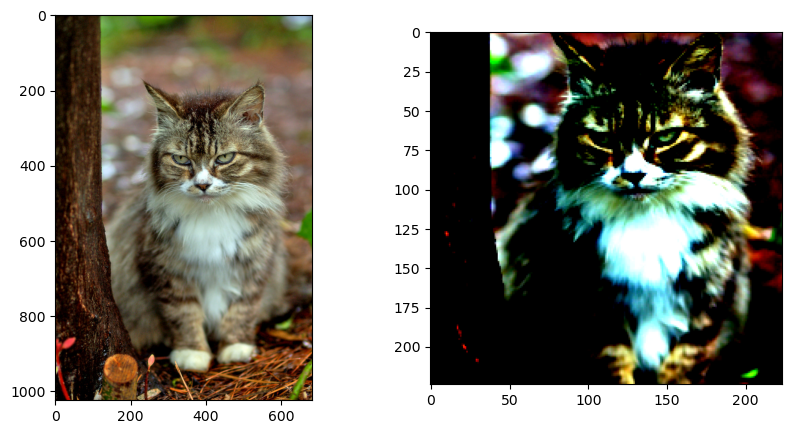

In [3]:
from torchvision.io import read_image
RN50_transformer = ResNet50_Weights.IMAGENET1K_V2.transforms( antialias=True)

cat = read_image( "images/cat.jpg" )
cat_t = RN50_transformer(cat)

fig,ax = plt.subplots(1,2 , figsize = (10,5))
## Tensor are in C,H,W shape, but imshow wants H,W,C
## so we move axis 0 to index 2
ax[0].imshow(torch.moveaxis(cat,0,2).numpy())  
ax[1].imshow(torch.moveaxis(cat_t,0,2).numpy())

In [4]:
RN50_dategories = np.array( ResNet50_Weights.DEFAULT.meta['categories'] )
RN50_dategories[:5]

array(['tench', 'goldfish', 'great white shark', 'tiger shark',
       'hammerhead'], dtype='<U30')

In [5]:
cat_t = cat_t.to(device)
with torch.no_grad():
    pred = RN50_model(cat_t.unsqueeze(0))
    class_probas = pred.squeeze(0).softmax(0)
    print( "class proba shape",class_probas.shape )
    print( 'probas:    ', class_probas[:5] , '...' )
    print( 'categories:',RN50_dategories[:5] , '...')
    


class proba shape torch.Size([1000])
probas:     tensor([0.0010, 0.0007, 0.0011, 0.0011, 0.0011]) ...
categories: ['tench' 'goldfish' 'great white shark' 'tiger shark' 'hammerhead'] ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


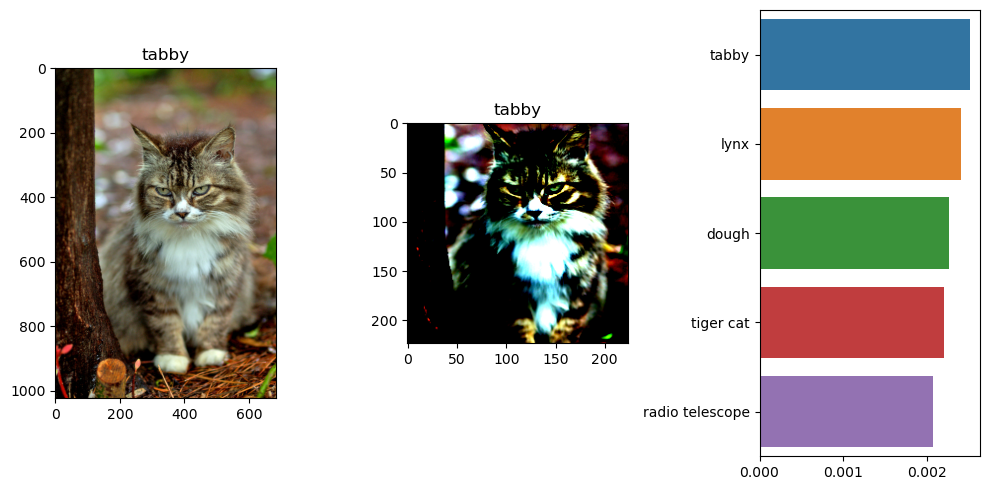

In [6]:
def RN50_predict( img ):
    img_t = RN50_transformer( img )

    img_t = img_t.to(device)
    with torch.no_grad():
        pred = RN50_model(img_t.unsqueeze(0))
        class_probas = pred.squeeze(0).softmax(0)
    
    order = np.argsort( class_probas.numpy()  )[::-1]
    
    fig,ax = plt.subplots(1,3 , figsize = (10,5))
    ax[0].imshow(torch.moveaxis(img,0,2).numpy())
    ax[0].set_title(RN50_dategories[order[0]])
    ax[1].imshow(torch.moveaxis(img_t,0,2).numpy())
    ax[1].set_title(RN50_dategories[order[0]])
    
    sns.barplot( x = class_probas.numpy()[order[:5]], 
             y = RN50_dategories[order[:5]] , ax = ax[2])
    plt.tight_layout()
RN50_predict( cat )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


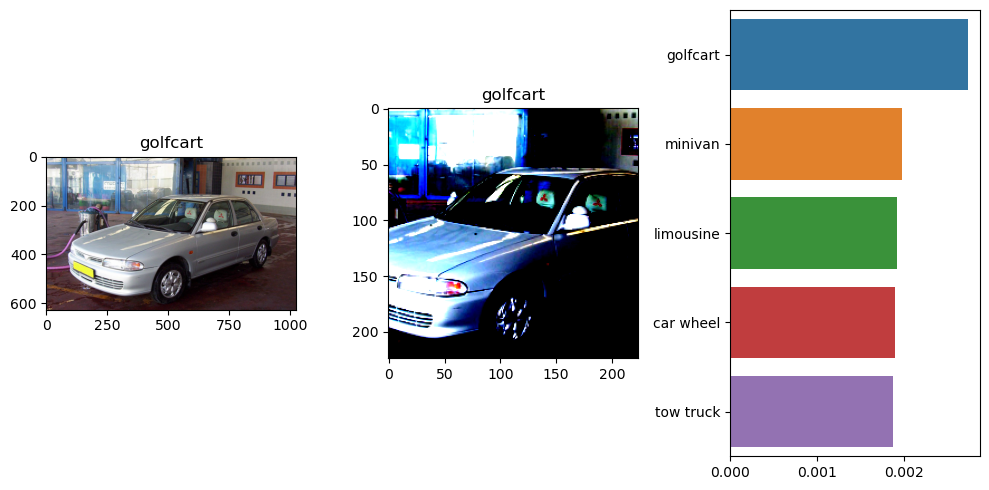

In [7]:
RN50_predict( read_image("images/car.jpg") )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


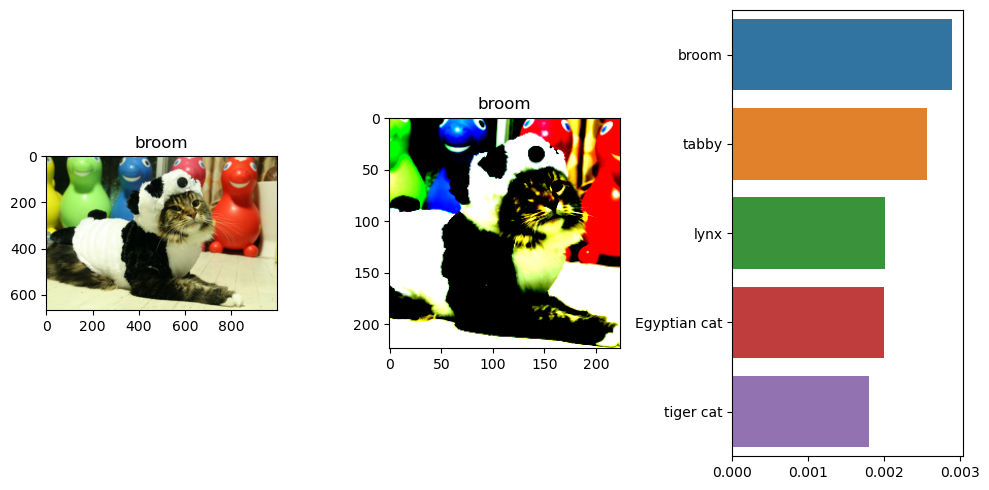

In [8]:
RN50_predict( read_image("images/pandas_cat.jpg") )

Now, if we try it on our x-ray images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


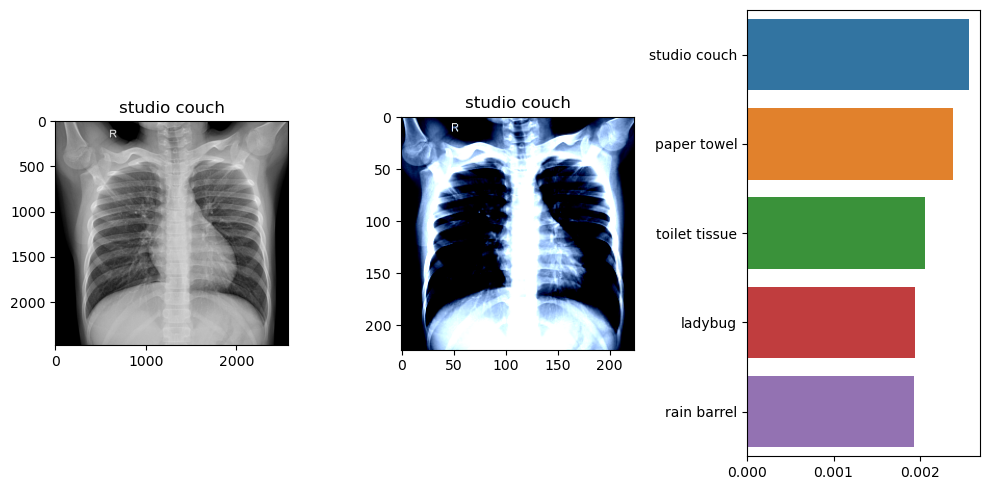

In [9]:
## force the image to be RGB
img = read_image("images/NORMAL-1003233-0001.jpeg" , 
                 mode=torchvision.io.ImageReadMode.RGB )

RN50_predict(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


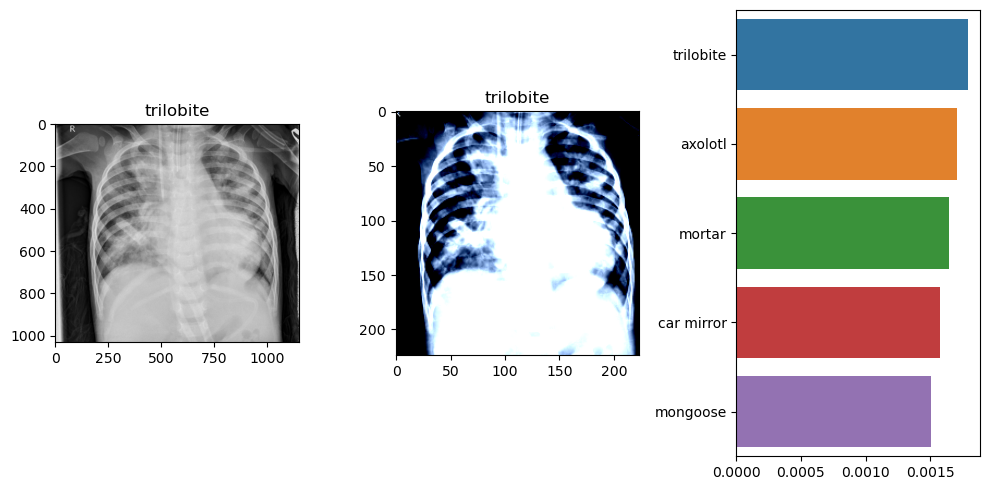

In [10]:
img = read_image("images/BACTERIA-1008087-0001.jpeg" , 
                 mode=torchvision.io.ImageReadMode.RGB )

RN50_predict(img)

As expected, it does not make sense.

---

## setting up transfer-learning

Rather than train a model from scratch as we did previously, we will leverage this complex model with [transfer learning](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks#parameter-tuning).

So we will freeze most layers of resnet50 and plug our own classifier on top.

![small Transfer Learning representation from https://stanford.edu/~shervine/teaching/cs-230/](https://stanford.edu/~shervine/teaching/cs-230/illustrations/transfer-learning-small-ltr.png?bee5e73de8fb2c6297a3a88804fabf5e)

In [11]:
cat_t = RN50_transformer(cat).to(device)
print(pms.summary(RN50_model, cat_t.unsqueeze(0) , show_input=True))

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [1, 3, 224, 224]           9,408           9,408
          BatchNorm2d-2     [1, 64, 112, 112]             128             128
                 ReLU-3     [1, 64, 112, 112]               0               0
            MaxPool2d-4     [1, 64, 112, 112]               0               0
           Bottleneck-5       [1, 64, 56, 56]          75,008          75,008
           Bottleneck-6      [1, 256, 56, 56]          70,400          70,400
           Bottleneck-7      [1, 256, 56, 56]          70,400          70,400
           Bottleneck-8      [1, 256, 56, 56]         379,392         379,392
           Bottleneck-9      [1, 512, 28, 28]         280,064         280,064
          Bottleneck-10      [1, 512, 28, 28]         280,064         280,064
          Bottleneck-11      [1, 512, 28, 28]         280,064  

In [12]:
RN50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# we freeze all layers by setting their parameters .requires_grad=False
for param in RN50_model.parameters():
    param.requires_grad = False

In [14]:
## the layer we want to replace is called fc

# Parameters of newly constructed modules have requires_grad=True by default
input_dim = RN50_model.fc.in_features

RN50_model.fc = nn.Sequential(nn.Linear(input_dim , 1),
                              nn.Sigmoid() )


In [15]:
cat_t = RN50_transformer(cat).to(device)
print(pms.summary(RN50_model, cat_t.unsqueeze(0) , show_input=True))

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [1, 3, 224, 224]           9,408               0
          BatchNorm2d-2     [1, 64, 112, 112]             128               0
                 ReLU-3     [1, 64, 112, 112]               0               0
            MaxPool2d-4     [1, 64, 112, 112]               0               0
           Bottleneck-5       [1, 64, 56, 56]          75,008               0
           Bottleneck-6      [1, 256, 56, 56]          70,400               0
           Bottleneck-7      [1, 256, 56, 56]          70,400               0
           Bottleneck-8      [1, 256, 56, 56]         379,392               0
           Bottleneck-9      [1, 512, 28, 28]         280,064               0
          Bottleneck-10      [1, 512, 28, 28]         280,064               0
          Bottleneck-11      [1, 512, 28, 28]         280,064  

## setup the dataloaders

In [16]:
read_image_rgb = lambda x : read_image(x , mode=torchvision.io.ImageReadMode.RGB)

train_dataset = torchvision.datasets.ImageFolder('data/chest_xray_224/train', 
                                         loader = read_image_rgb,
                                         transform = RN50_transformer,
                                         target_transform = lambda x : torch.Tensor([x])  )
valid_dataset = torchvision.datasets.ImageFolder('data/chest_xray_224/test', 
                                         loader = read_image_rgb,
                                         transform = RN50_transformer,
                                         target_transform = lambda x : torch.Tensor([x])   )
    
    
batch_size = 64
train_dataloader = DataLoader( dataset= train_dataset , shuffle=True , batch_size = batch_size )
valid_dataloader = DataLoader( dataset= valid_dataset , shuffle=True , batch_size = batch_size )


In [17]:
X,y = next(iter(train_dataloader))
X.shape , y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 1]))

In [18]:
%%time
loss = nn.BCELoss()

with torch.no_grad():
    pred = RN50_model(X.to(device))
    print(pred.shape)
    print( 'avg loss:', loss( pred , y ) )

torch.Size([64, 1])
avg loss: tensor(0.6864)
CPU times: user 14.8 s, sys: 2.53 s, total: 17.3 s
Wall time: 4.34 s


From there we would train the model as we usually do.

However, in that particular case you can notice that just predicting 1 batch of 64 images took almost 4s on my measly CPU.

So to go through the 5,858 images of the dataset:

In [19]:
((4/64)*5858)/60

6.102083333333334

I would need about 6 minutes.

So I would have fairly long epochs, and that is without even counting the backward pass.

Now, I could upgrade to a computer with a good GPU, but I could also apply reason like follow:

 * We have fixed all layers of Resnet50, expect the last
 * So at each epoch we compute the same thing, except for the last component
 * Going through all these layers is time consuming
 * Why not go though all these fixed layers once, and then train a model on this
 
Basically, we would use a truncated Resnet50 model as a way to embed our 224x224 image (~50,176 pixels) into a 2048 feature space.

And then we would train a classifier from that space

**exercise** : modify the last layer so it does not modify the output and compute the embedding for 1 batch.

In [20]:
# %load solutions/TL_resnet50_embed.py

---
> What follow is the precomputation of the embeddings, which takes about 7min.

In [ ]:
# %load solutions/embed_all.py

## Exercise: fit the embedded data

setup your dataloaders, create your model, and train it

setup dataloader

In [28]:
# %load -r 1-17 solutions/TL_model_embed.py

define model

In [29]:
# %load -r 18-44 solutions/TL_model_embed.py

define helper functions

In [30]:
# %load -r 45-111 solutions/TL_model_embed.py

training setup

In [31]:
# %load -r 112-127 solutions/TL_model_embed.py

initial round

In [32]:
# %load -r 128-140 solutions/TL_model_embed.py

training

In [33]:
# %load -r 141-171 solutions/TL_model_embed.py

results

In [34]:
# %load -r 172- solutions/TL_model_embed.py



## merging the two models

In [35]:
import copy
RN50_model.fc = copy.deepcopy( model.layers )

## saving and loading the model

In [36]:
## saving 
torch.save(RN50_model, "modified_RN50.model") 

## loading
RN50_model_loaded = torch.load( "modified_RN50.model") 
RN50_model_loaded

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## extra task: don't limit yourself to Neural Networks 

once you have the embedding you can apply whatever ML methodology you want.


In [35]:
from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform( X_train )
pca.explained_variance_ratio_

array([2.88586200e-02, 2.53233187e-02, 2.20591951e-02, ...,
       1.19191443e-05, 7.31986956e-06, 4.00686503e-06])

<Axes: >

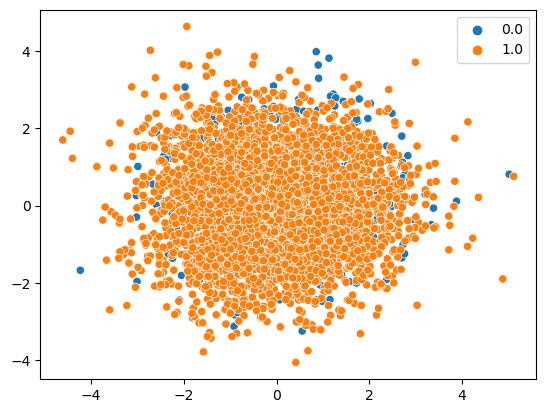

In [36]:
sns.scatterplot( x = x_pca[:,0] , y = x_pca[:,1] , hue = y_train )

In [37]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

logi_r=LogisticRegression(solver = 'liblinear',n_jobs=1) 

pipeline_lr=Pipeline([('model',logi_r)])



grid_values = {'model__C': np.logspace(-1,0,10),
               'model__penalty': ['l1'] }

grid_lr = GridSearchCV(pipeline_lr, 
                           param_grid = grid_values, 
                           scoring='accuracy',
                           cv=5,
                           n_jobs=1)
grid_lr.fit( X_train , y_train )
print('Grid best parameter (max. accuracy): ', grid_lr.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_lr.best_score_)#get the best score calculated from the train/validation dataset
print('validatio set score:' ,accuracy_score(y_valid , grid_lr.predict(X_valid)) )

Grid best parameter (max. accuracy):  {'model__C': 1.0, 'model__penalty': 'l1'}
Grid best score (accuracy):  0.898696448561948
validatio set score: 0.8173076923076923
CPU times: user 1min 10s, sys: 3.82 s, total: 1min 13s
Wall time: 44.9 s
